In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [3]:
from scipy.ndimage import rotate
from scipy.ndimage import zoom

from jax.scipy.interpolate import RegularGridInterpolator

In [4]:
from microscope_calibration.stemoverfocus import (
    solve_model_fourdstem_wrapper, 
    find_input_slopes, 
    ray_coords_at_plane,
)
from microscope_calibration.generate import compute_fourdstem_dataset, do_shifted_sum, compute_scan_grid_rays_and_intensities
from microscope_calibration import components as comp

In [5]:
import numpy as np
import jax.numpy as jnp

In [6]:
from microscope_calibration import components as comp
from microscope_calibration.model import ModelParameters, create_stem_model

In [7]:
sample_image = test_image = np.zeros((7, 9), dtype=np.uint8)
test_image[0, 0] = 1
test_image[0, -1] = 2
test_image[-1, -1] = 3
test_image[-1, 0] = 4

In [14]:
params_dict = model_params = ModelParameters(
    semi_conv=0.0001,
    defocus=.001,
    camera_length=0.1,
    scan_shape=(10, 10),
    det_shape=(64, 64),
    scan_step=(0.001, 0.001),
    det_px_size=(0.001, 0.001),
    scan_rotation=0.0,
    descan_error = jnp.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
)

In [15]:
stem_model = model = create_stem_model(params_dict)

In [16]:
scan_step = model_params['scan_step']

# Downsample the sample_image by a factor of 2
downsample_factor = 1.0
sample_image = zoom(sample_image, downsample_factor)

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = model_params['scan_rotation']

sample_image = np.array(sample_image, dtype=np.complex64)
sample_px_size = scan_step
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size[0]
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size[1]

# Set up grid coordinates corresponding to the physical centers of the pixels.
# Note: We use the rotated image’s physical edge lengths (sample_rotated_edge_length_x/y)
# to generate coordinates that match each pixel center.
sample_coords_x = np.linspace(-sample_rotated_edge_length_x/2,
                            +sample_rotated_edge_length_x/2,
                            sample_rotated.shape[1])

sample_coords_y = np.linspace(-sample_rotated_edge_length_y/2,
                            +sample_rotated_edge_length_y/2,
                            sample_rotated.shape[0])

# Flip the y-axis of the sample_rotated image because regular grid interpolator from jax cannot 
# handle a positive to negative grid coordinate
sample_rotated_flipped = np.flipud(sample_rotated)

# Build the RegularGridInterpolator
sample_interpolant = RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated_flipped,
    method='nearest', bounds_error=False, fill_value=0.0
)

Scan Y: 100%|██████████| 100/100 [00:00<00:00, 1446.82it/s]
/tmp/ipykernel_1600247/3360597717.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  detector_intensities = np.array(detector_intensities, dtype=np.float32).flatten()


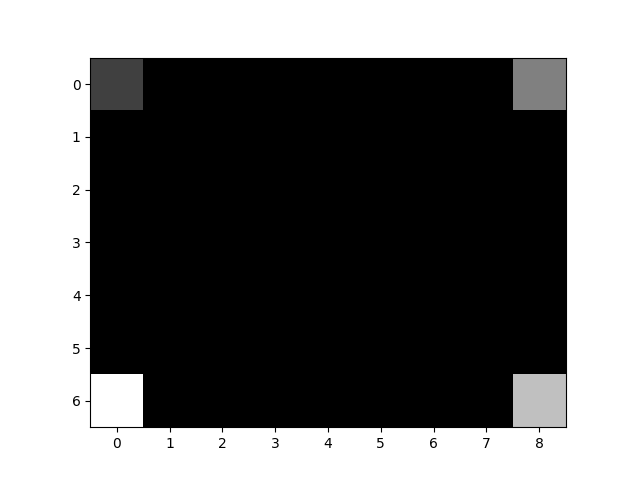

In [17]:

img = test_image
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')


PointSource, ScanGrid, Descanner, Detector = model

fourdstem_array = jnp.zeros((ScanGrid.scan_shape[0]*ScanGrid.scan_shape[1], *Detector.det_shape), dtype=jnp.complex64)

fourdstem_array = compute_fourdstem_dataset(
    stem_model, fourdstem_array, sample_interpolant
)

sample_px_ys, sample_px_xs, detector_intensities = compute_scan_grid_rays_and_intensities(
    stem_model, fourdstem_array.reshape(-1, *Detector.det_shape)
)

sample_px_ys = np.array(sample_px_ys, dtype=np.int32).flatten()
sample_px_xs = np.array(sample_px_xs, dtype=np.int32).flatten()
detector_intensities = np.array(detector_intensities, dtype=np.float32).flatten()

In [18]:
shifted_sum_image = np.zeros(ScanGrid.scan_shape, dtype=np.float32)
shifted_sum_image = do_shifted_sum(shifted_sum_image, sample_px_ys, sample_px_xs, detector_intensities)

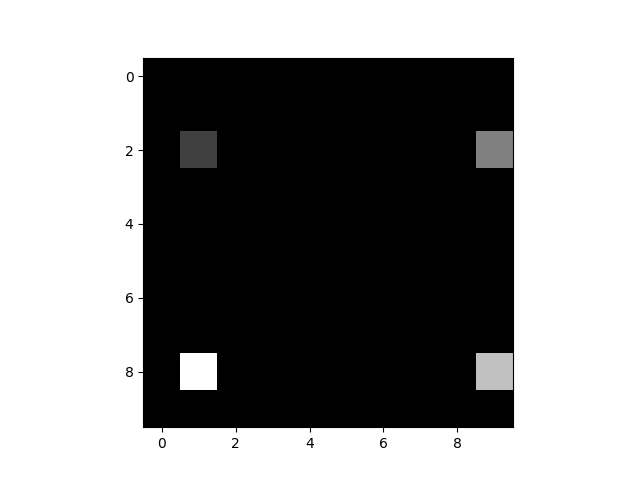

In [19]:
fig, ax = plt.subplots()
ax.imshow(shifted_sum_image, cmap='gray')